In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

current_path = sys.path[0]
sys.path.append(current_path[:current_path.find('defi-measurement')] + "liquidity-distribution-history")

In [3]:
import os
from pool_state import v3Pool
import numpy as np
import matplotlib.pyplot as plt
import random

import json

import pandas as pd
from prisma import Prisma
from tqdm import tqdm

from sqlalchemy import create_engine

from dotenv import load_dotenv

# Use web3 to convert wei to ETH
from web3 import Web3
w3 = Web3()

load_dotenv(override=True)

True

In [5]:
postgres_uri = os.environ["POSTGRESQL_URI_US"]

pool_symbols = json.load(open("../addresses/pool_tokens.json", "r"))

# Take out the 10 first pools of the dictionary
# pool_symbols = {k: pool_symbols[k] for k in list(pool_symbols)[:10]}
client = Prisma()
await client.connect()

print(f"{await client.swap.count():_}")

399_157


In [ ]:
swaps_v3 = await client.swap.find_many()
swap_df = pd.DataFrame([swap.dict() for swap in swaps_v3])

# Filter out certain swaps if needed
swap_df.address = swap_df.address.str.lower()

swap_df.amount0 = swap_df.amount0.astype(float)
swap_df.amount1 = swap_df.amount1.astype(float)

print(f"{swap_df.block_number.nunique():,} blocks from {swap_df.block_timestamp.min()} to {swap_df.block_timestamp.max()}")

In [ ]:
filtered_df = swap_df[swap_df.address == "0x5777d92f208679db4b9778590fa3cab3ac9e2168"]

print(f"{filtered_df.block_number.nunique():,} blocks from {filtered_df.block_timestamp.min()} to {filtered_df.block_timestamp.max()}")

1,338 blocks from 2023-06-16 22:28:11+00:00 to 2023-06-26 12:44:59+00:00


In [ ]:
swapcounts = filtered_df.groupby(['block_number', 'address']).count().transaction_hash.sort_values(ascending=False)

swapcounts.head()

block_number  address                                   
17563681      0x5777d92f208679db4b9778590fa3cab3ac9e2168    3
17542788      0x5777d92f208679db4b9778590fa3cab3ac9e2168    3
17551511      0x5777d92f208679db4b9778590fa3cab3ac9e2168    3
17529606      0x5777d92f208679db4b9778590fa3cab3ac9e2168    2
17531626      0x5777d92f208679db4b9778590fa3cab3ac9e2168    2
Name: transaction_hash, dtype: int64

In [ ]:
print(f'More than 3 swaps: {(swapcounts > 3).sum():,} / {swapcounts.shape[0]:,} ({(swapcounts > 3).sum() / swapcounts.shape[0]:.2%})')
print(f'More than 4 swaps: {(swapcounts > 4).sum():,} / {swapcounts.shape[0]:,} ({(swapcounts > 4).sum() / swapcounts.shape[0]:.2%})')

More than 3 swaps: 0 / 1,338 (0.00%)
More than 4 swaps: 0 / 1,338 (0.00%)


In [ ]:
# pool_address = "0x5777d92f208679db4b9778590fa3cab3ac9e2168"
# block_number = 17_500_000

# Start with block and pool with the most swaps
block_number = int(swapcounts.index.get_level_values(0).values[0])
pool_address = str(swapcounts.index.get_level_values(1)[0])


In [ ]:

pool_info = pool_symbols[pool_address]
swap_block = filtered_df[(filtered_df.block_number == block_number) & (filtered_df.address == pool_address)]

print(f'{swap_block.shape[0]:,} swaps in block {block_number:,} for pool {pool_info["name"]}')

tokens = [pool_info['token0'], pool_info['token1']]

swap_block.head()

3 swaps in block 17,563,681 for pool DAI-USDC


,transaction_hash,block_timestamp,block_number,transaction_index,log_index,sender,recipient,amount0,amount1,sqrtPriceX96,liquidity,tick,address,from_address,to_address,from_mempool
398987,0x308722bac25bf4500a6797f632592c2168a375d42115...,2023-06-26 12:44:59+00:00,17563681,80,235,0xE592427A0AEce92De3Edee1F18E0157C05861564,0xA915B9C104F865105Caa29E122C8e558cC22bd41,-5.588242e+20,558856739.0,79226504828456508699290,534046179011700564897028,-276325,0x5777d92f208679db4b9778590fa3cab3ac9e2168,0xE592427A0AEce92De3Edee1F18E0157C05861564,0xA915B9C104F865105Caa29E122C8e558cC22bd41,True
398992,0x308722bac25bf4500a6797f632592c2168a375d42115...,2023-06-26 12:44:59+00:00,17563681,80,297,0xE592427A0AEce92De3Edee1F18E0157C05861564,0xA915B9C104F865105Caa29E122C8e558cC22bd41,7.216714e+19,-72156900.0,79226504817751706611492,534046179011700564897028,-276325,0x5777d92f208679db4b9778590fa3cab3ac9e2168,0xE592427A0AEce92De3Edee1F18E0157C05861564,0xA915B9C104F865105Caa29E122C8e558cC22bd41,True
398996,0x308722bac25bf4500a6797f632592c2168a375d42115...,2023-06-26 12:44:59+00:00,17563681,80,334,0xE592427A0AEce92De3Edee1F18E0157C05861564,0xA915B9C104F865105Caa29E122C8e558cC22bd41,6.292104e+19,-62912110.0,79226504808418410861161,534046179011700564897028,-276325,0x5777d92f208679db4b9778590fa3cab3ac9e2168,0xE592427A0AEce92De3Edee1F18E0157C05861564,0xA915B9C104F865105Caa29E122C8e558cC22bd41,True


### 1. Historical Liquidity Distribution / Market Depth
* Useful when investors want to manually investigate liquidity distribution in history
* Current implementation: 
    - Input: as_of (can be intra-block)
    - Output: liquidity at each tick
* Quick iteration:
    - Input: time_range, frequency
    - Output: dataframe of liquidity distribution at each point in time + gif displaying liquidity dynamics


In [ ]:
print(f"""
pool_add              = "{pool_address}"  # {pool_symbols[pool_address]['name']}
block_number          = {block_number:_}
""")


pool_add              = "0x5777d92f208679db4b9778590fa3cab3ac9e2168"  # DAI-USDC
block_number          = 17_563_681



## Test the baseline case with Liquidity for USD/ETH 0.3%

In [ ]:
def plot_liquidity(pool: v3Pool, block_number, transaction_index, display_price_lower, display_price_upper, initialize=False):
    as_of = block_number + transaction_index / 1e4
    x, y = pool.createLiq(as_of)
    x, y = np.array(x), np.array(y)
    px = pool.getPriceAt(as_of)
    
    assert isinstance(px, float)

    liq_df = pd.DataFrame(x, columns=["ticks"])
    liq_df["liquidity"] = y
    liq_df['px'] = 1 / (1.0001 ** liq_df['ticks']) * 1e12  # \sqrt{P} \cdot x = L ???

    plot_df = liq_df[(liq_df['px'] < display_price_upper) & (liq_df['px'] > display_price_lower)].set_index("px")

    fig, ax = plt.subplots()

    ax.plot(plot_df['liquidity'], label = "Liquidity at tick", color = 'mediumpurple')
    ax.axvline((1 / px ** 2) * 1e12, color = 'black', linestyle = "--")
    ax.legend()
    ax.set_ylabel("Liquidity (in billions)")
    ax.set_xlabel("Price (USDC/ETH)")
    ax.set_title(f'Liquidity Distribution as of block number {int(as_of)}')

    # Make the x-axis be logarithmic
    ax.set_xscale('log')

    return fig, ax

Initializing liquidity


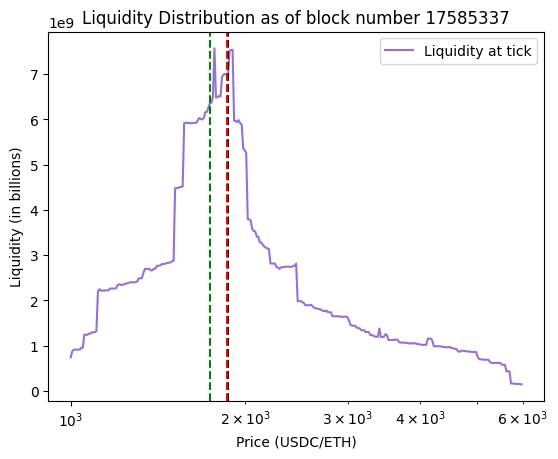

In [ ]:
########### INPUT BLOCK ###############

pool_add              = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'
block_number          = 17_585_337
transaction_index     = 0
display_price_lower   = 1000
display_price_upper   = 6000

#######################################

pool = v3Pool(
    poolAdd=pool_add,
    connStr=postgres_uri,
    initialize=False,
    update=False,
)

_, ax = plot_liquidity(pool, block_number, transaction_index, display_price_lower, display_price_upper)

# Add vertical lines for the initial price = 1860 and the price after 100 swaps = 1740 in distinct colors
ax.axvline(1860, color='red', linestyle="--")
ax.axvline(1740, color='green', linestyle="--");

## Run single swap on Uniswap V3 USDC/ETH 0.3% and compare with realized price

In [6]:
pool_add              = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'
%prun pool = v3Pool(pool_add, initialize=False, connStr=postgres_uri)

         67650 function calls (66099 primitive calls) in 226.302 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       13  133.647   10.281  133.647   10.281 {method 'execute' of 'psycopg2.extensions.cursor' objects}
        4   46.712   11.678   46.712   11.678 result.py:557(<listcomp>)
      128   24.867    0.194   25.246    0.197 {pandas._libs.lib.maybe_convert_objects}
        4    8.579    2.145    8.579    2.145 {method 'fetchall' of 'psycopg2.extensions.cursor' objects}
        4    4.243    1.061    4.243    1.061 {pandas._libs.lib.to_object_array_tuples}
        4    1.886    0.472   31.912    7.978 sql.py:168(_wrap_result)
        2    1.308    0.654    1.308    0.654 {built-in method psycopg2._psycopg._connect}
        4    1.212    0.303   56.786   14.197 result.py:1325(fetchall)
        4    0.944    0.236  224.390   56.097 sql.py:513(read_sql)
       16    0.569    0.036    0.569    0.036 {method 'factorize' 

In [7]:
block_number          = 17_585_337
block_number          = 17_585_278
transaction_index     = 0
swapParams            = {'tokenIn': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',   # WETH
                         'tokenOut': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',  # USDC
                        #  'input': 61004439033357074432,
                         'input': w3.to_wei(130.128764511365, 'ether'),
                         'gasFee': True,
                         'as_of': block_number + transaction_index / 1e4}

ground_truth = pool.swap_in(swapParams, fees=True)

Initializing liquidity


In [8]:
%%timeit -n 100 -r 10
pool.swap_in(swapParams, fees=True)

32.9 ms ± 411 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [9]:
# Compare res_1 with ground_truth
res_1 = pool.swap_in(swapParams, fees=True)
assert res_1[0] == ground_truth[0]

In [10]:
%%timeit -n 100 -r 10
pool.swap_in(swapParams, fees=True)

33 ms ± 209 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [11]:
# Compare res_1 with ground_truth
res_2 = pool.swap_in(swapParams, fees=True)
assert res_2[0] == ground_truth[0]

In [15]:
%%timeit -n 100 -r 10
pool.swap_in(swapParams, fees=True)

33.4 ms ± 1.11 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [16]:
# Compare res_1 with ground_truth
res_3 = pool.swap_in(swapParams, fees=True)
assert res_3[0] == ground_truth[0]

In [17]:
%%timeit -n 100 -r 10
pool.swap_in(swapParams, fees=True)

32.6 ms ± 499 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [18]:
# Compare res_1 with ground_truth
res_4 = pool.swap_in(swapParams, fees=True)
assert res_4[0] == ground_truth[0]

In [22]:
%%timeit -n 100 -r 10
pool.swap_in(swapParams, fees=True)

33.7 ms ± 1.66 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [23]:
# Compare res_1 with ground_truth
res_5 = pool.swap_in(swapParams, fees=True)
assert res_5[0] == ground_truth[0]

In [18]:
%%time
########### INPUT BLOCK ###############

block_number          = 17_585_337
block_number          = 17_585_278
transaction_index     = 0
swapParams            = {'tokenIn': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',   # WETH
                         'tokenOut': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',  # USDC
                        #  'input': 61004439033357074432,
                         'input': w3.to_wei(130.128764511365, 'ether'),
                         'gasFee': True,
                         'as_of': block_number + transaction_index / 1e4}
    
#######################################

output, heur = pool.swapIn(swapParams, fees=True)

sqrtPrice_next = heur.sqrtP_next

print(f'Got {output} out')
print(f'Heuristics:')
print(json.dumps(heur._asdict(), indent=4))

Initializing liquidity
Got 242759171949 out
Heuristics:
{
    "totalFee": 390386293534095040,
    "crossed_ticks": 0,
    "liquidity_in_range": 7518682933.496858,
    "sqrt_P": 23109.1688988636,
    "sqrtP_next": 23126.424364929317,
    "tickToFees": {
        "200940": 51922164.69122081
    },
    "inRangeTest": 2.6304760269305437e+20,
    "swapInMinusFee": 1.297383782178309e+20,
    "zeroForOne": false,
    "gas_fee": 0.005848064963025693
}
CPU times: user 158 ms, sys: 93.5 ms, total: 252 ms
Wall time: 251 ms


In [19]:
%%time
########### INPUT BLOCK ###############
block_number          = 17_585_337
transaction_index     = 0
swapParams            = {'tokenIn': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',   # WETH
                         'tokenOut': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',  # USDC
                         'input': 61004439033357074432,
                         'gasFee': True,
                         'givenPrice': sqrtPrice_next,
                         'as_of': block_number + transaction_index / 1e4}

#######################################

output, heur = pool.swapIn(swapParams, fees=True)

print(f'Got {output / 1e6:_.2f} out (113_679.81)')
print(f'Heuristics:')
print(json.dumps(heur._asdict(), indent=4))

Got 113_680.96 out (113_679.81)
Heuristics:
{
    "totalFee": 183013317100071232,
    "crossed_ticks": 0,
    "liquidity_in_range": 7518682933.496858,
    "sqrt_P": 23126.424364929317,
    "sqrtP_next": 23134.513737264104,
    "tickToFees": {
        "200940": 24341140.425634857
    },
    "inRangeTest": 1.3330922447522767e+20,
    "swapInMinusFee": 6.0821425716257006e+19,
    "zeroForOne": false,
    "gas_fee": 0.004136525281207392
}
CPU times: user 58.4 ms, sys: 12.2 ms, total: 70.6 ms
Wall time: 70 ms


100%|██████████| 100/100 [00:06<00:00, 15.03it/s]


CPU times: user 5.76 s, sys: 952 ms, total: 6.71 s
Wall time: 6.71 s


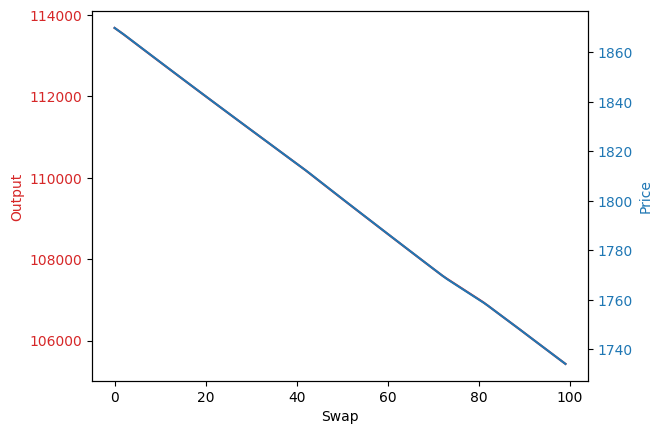

In [20]:
%%time
########### INPUT BLOCK ###############
block_number          = 17_585_337
transaction_index     = 0
swapParams            = [{'tokenIn': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',   # WETH
                         'tokenOut': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',  # USDC
                         'input': 61004439033357074432,
                         'gasFee': True,
                         'as_of': block_number + 0 / 1e4} for i in range(100)]

#######################################

sqrtPrice_next = pool.getPriceAt(block_number + 0 / 1e4)

outputs = []
prices = []

for s in tqdm(swapParams):
    s['givenPrice'] = sqrtPrice_next
    output, heur = pool.swapIn(s, fees=True)
    sqrtPrice_next = heur.sqrtP_next
    outputs.append(output / 1e6)
    prices.append(1 / (heur.sqrt_P**2 / 1e12))


# Plot the results on different axes

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Swap')
ax1.set_ylabel('Output', color=color)
ax1.plot(outputs, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


color = 'tab:blue'
ax2.set_ylabel('Price', color=color)  # we already handled the x-label with ax1
ax2.plot(prices, color=color)
ax2.tick_params(axis='y', labelcolor=color)


In [22]:
from decimal import Decimal, getcontext

getcontext().prec = 100  # Set the precision high enough for our purposes

def convert_sqrtPriceX96_to_price(sqrtPriceX96: str, decimals=2) -> float:
    # Assume sqrtPriceX96 is the value you got from the swap event
    # Square it and shift it right by 96 places (rescaling for fixed-point format)
    sqrtPrice = Decimal(sqrtPriceX96)  / Decimal(2**96)

    # The result is the price of token1 in terms of token0 (after rounding down)
    raw_price = sqrtPrice ** Decimal(2)

    adj_price = float((raw_price * Decimal(1e6) / Decimal(1e18)))

    price = 1 / adj_price

    return price if decimals is None else round(price, decimals)

convert_sqrtPriceX96_to_price('1832874851818827674680023334174902')

1868.5

## Run simulations with one block of USDC/ETH

### Get the data

In [48]:
# Create the pool object
pool_add = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'
pool = v3Pool(pool_add, initialize=False, connStr=postgres_uri)

In [49]:
engine = create_engine(postgres_uri)

In [50]:
df = pd.read_sql(
    f"""
        SELECT *
        FROM swaps
        WHERE address = '{pool_add}'
            AND block_number >= 13000000;
    """,
    con=engine,
)

In [51]:
# Start by looking at blocks with 5 or more swaps
df = df[df['block_number'] >= 13_000_000]
swap_counts = df.groupby(by=['block_number']).count().sort_values(by=['transaction_index'], ascending=False).block_ts
swap_counts = swap_counts[swap_counts >= 5]

print(swap_counts.shape)

# Print the first 10 blocks with 5 or more swaps
swap_counts.head(10)

(558,)


block_number
15154740    19
15826457    13
14960085    11
15583393    11
14266329    11
15935648    11
14959213    11
15053194    10
14976125    10
14242526    10
Name: block_ts, dtype: int64

### Test run for one block with many transactions

In [52]:
print(f'Pool swaps between {pool.token0} and {pool.token1}')

Pool swaps between 0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48 and 0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2


In [53]:
def get_swap_df_from_block(df, block_number):
    # Get the swaps for this block
    swaps = df[df.block_number == block_number]
    swaps = swaps.sort_values(by=['transaction_index'])

    # Get the columns we're interested in
    swaps = swaps[['block_number', 'transaction_index', 'log_index', 'amount0', 'amount1', 'sqrtpricex96', 'tick', 'tx_hash', 'block_ts']]

    # Convert sqrtPriceX96 to price
    swaps['price'] = swaps.sqrtpricex96.apply(convert_sqrtPriceX96_to_price)

    # Add column indicating sell or buy
    swaps['direction'] = swaps.apply(lambda x: 'sell' if int(x.amount0) < 0 else 'buy', axis=1)

    return swaps

In [54]:
def sqrt_to_price(sp: float) -> float:
    return 1 / (sp**2 / 1e12)

In [55]:
def get_swap_params(pool: v3Pool, swaps: pd.DataFrame) -> list:
    # Convert the dataframe into a list of swap parameter dicts
    swaps_parameters = []
    for row in swaps.to_dict(orient='records'):
        # Calculate what is tokenIn and what is tokenOut
        token_in = pool.token0
        amount0 = str(row['amount0'])
        if str(row['amount0'])[0].startswith('-'):
            token_in = pool.token1
            amount0 = str(row['amount1'])

        amount0 = int(amount0)

        swapParams = {'tokenIn': token_in,
                    'input': amount0,
                    'gasFee': True,
                    'as_of': row['block_number'] + 0 / 1e4}

        swaps_parameters.append(swapParams)

    return swaps_parameters

In [56]:
def run_simulation(pool: v3Pool, block_number: int, swaps_parameters: list, pbar=True) -> np.ndarray:
    # Make a copy of swaps_parameters
    swaps_parameters = [s.copy() for s in swaps_parameters]

    # Get the sqrtPriceX96 at the start of the block
    sqrtPrice_next = pool.getPriceAt(block_number + 0 / 1e4)

    prices = np.zeros(len(swaps_parameters), dtype=np.float64)

    for i, s in tqdm(enumerate(swaps_parameters), disable=not pbar):
        s['givenPrice'] = sqrtPrice_next
        _, heur = pool.swapIn(s, fees=True)
        sqrtPrice_next = heur.sqrtP_next
        prices[i] = 1 / (heur.sqrt_P**2 / 1e12)

    return prices

In [57]:
def plot_prices(prices: np.ndarray, block_number: int, ax=None) -> None:
    if not ax:
        fig, ax = plt.subplots()
    
    # Plot the prices
    ax.plot(prices)

    # Calculate the average price and standard deviation
    avg_price = np.mean(prices)
    std_price = np.std(prices)

    # Plot the price at the start of the block
    ax.axhline(prices[0], color='b', linestyle='--', label=f'$p_0$ = {prices[0]:>7.2f}')

    # Plot the average price
    ax.axhline(avg_price, color='r', linestyle='--', label=f'$\mu$ = {avg_price:>7.2f}')

    # Plot the standard deviation
    ax.axhline(avg_price + std_price, color='g', linestyle='--')
    ax.axhline(avg_price - std_price, color='g', linestyle='--', label=f'$\sigma$ = {std_price:>7.2f}')

    # Make the x-axis integers
    ax.set_xticks(np.arange(len(prices)), np.arange(len(prices)));

    # Make the plot nice
    ax.set_title(f'Price of ETH in USDC for block {block_number:_}')
    ax.set_xlabel(f'Swap # in block ({len(prices)} total)')
    ax.set_ylabel('Price (USDC/ETH)')

    ax.legend()    
    ax.grid()

In [58]:
# Test for the block with the most swaps
block_number = swap_counts.index[2]

swaps = get_swap_df_from_block(df, block_number)
swaps

,block_number,transaction_index,log_index,amount0,amount1,sqrtpricex96,tick,tx_hash,block_ts,price,direction
131687,14960085,14,34,-7339882207,6000000000000000000,2261861264151729734063228781720603,205197,0x0881b8f3cf337aea94181732fd53935c0a377a980218...,2022-06-14 05:28:14,1226.95,sell
182377,14960085,18,39,-6062654935,4956250000000000000,2261927688933093460258939978031604,205198,0x9736ae48d52ada7643558612d637660df1394a53b491...,2022-06-14 05:28:14,1226.88,sell
186926,14960085,46,91,-2667455367,2180750000000000000,2261956915836893499785052904408444,205198,0x7b4037a482ae96224a5dff11c3c057561921a9536ee3...,2022-06-14 05:28:14,1226.85,sell
98031,14960085,82,128,-50401777022,41216000000000000000,2262506366639021199589084622850088,205203,0x0c87bc1cb13aa16f505b7a25ed3e711b4c95bcb07f9a...,2022-06-14 05:28:14,1226.25,sell
106088,14960085,145,283,-9691341576,7927375482506644405,2262611781730888484032203203494312,205204,0x4c31291ec43c31ad12658ce7af4368347a9a5cfb49a5...,2022-06-14 05:28:14,1226.14,sell
152845,14960085,217,414,-305614255,250000000000000000,2262615106131634352073293223203596,205204,0xd46c97a7f1172a5354f5a96cc76e2d489c5df29cb201...,2022-06-14 05:28:14,1226.13,sell
162087,14960085,227,438,-12223833844,10000000000000000000,2262748082161469073716894011574964,205205,0xbb85dd26acf6bef4fcc9200f4e910559112a892323b4...,2022-06-14 05:28:14,1225.99,sell
181569,14960085,239,462,-464477350,380000000000000000,2262753135250602793139350841533076,205205,0x5ab7930e126fd4228b0e72bf62da6d1d59f7f0e0b2fa...,2022-06-14 05:28:14,1225.98,sell
102360,14960085,246,475,-10327973579,8450000000000000000,2262865499995813132928193507706882,205206,0x0b145d1ac3aadc32abf39a1d6a63228957733daa192b...,2022-06-14 05:28:14,1225.86,sell
140357,14960085,249,487,-8799352209,7200000000000000000,2262962616538437530217387618798698,205207,0xeb9979f68d054964c5bd941af027fe8a6f1e436ad395...,2022-06-14 05:28:14,1225.76,sell


In [59]:
# Run the simulation with the real transaction order
swaps_parameters = get_swap_params(pool, swaps)

block_number = int(swap_counts.index.values[0])

prices = run_simulation(pool, block_number, swaps_parameters)

1it [00:00,  5.57it/s]

Initializing liquidity


11it [00:00, 16.87it/s]


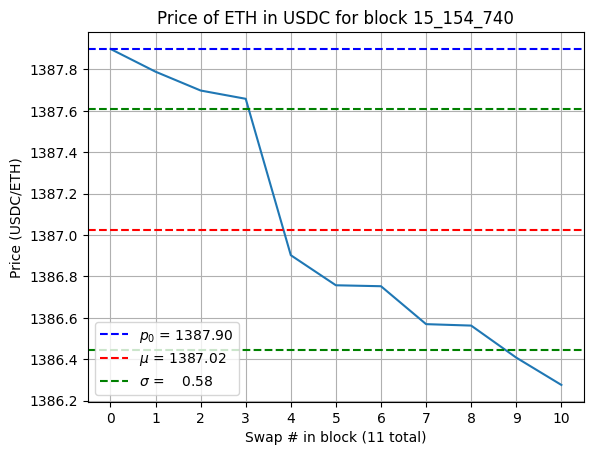

In [60]:
plot_prices(prices, block_number)

### Run same as above except try and interleave buy and sell

In [61]:
def interleave_swaps(swaps_parameters: list) -> list:
    buys_params = sorted([s for s in swaps_parameters if s['tokenIn'] == pool.token0], key=lambda x: x['input'], reverse=True)
    sells_params = sorted([s for s in swaps_parameters if s['tokenIn'] == pool.token1], key=lambda x: x['input'], reverse=True)

    shortest = min(len(buys_params), len(sells_params))

    # Interleave the buys and sells
    interleaved_swaps_parameters = [val for pair in zip(buys_params, sells_params) for val in pair]

    interleaved_swaps_parameters += buys_params[shortest:] + sells_params[shortest:]

    return interleaved_swaps_parameters


11it [00:00, 22.07it/s]


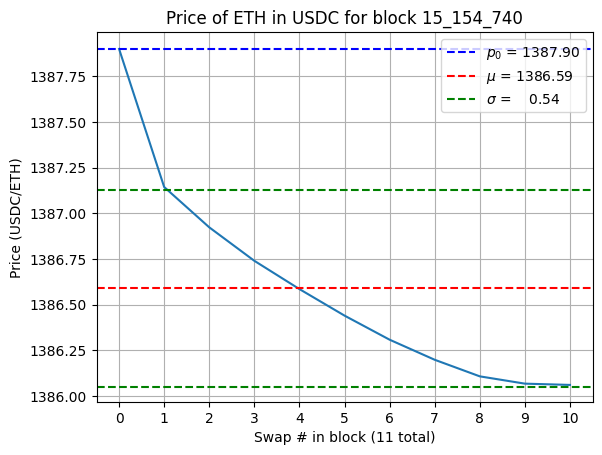

In [62]:
interleaved_swaps_parameters = interleave_swaps(swaps_parameters)

# Run the simulation with the interleaved buys and sells
interleaved_prices = run_simulation(pool, block_number, interleaved_swaps_parameters)

plot_prices(interleaved_prices, block_number)

### Run same as above with random permutations

In [63]:
def get_swap_params_random(swaps_parameters: list) -> list:
    swaps_parameters_random = swaps_parameters.copy()
    random.shuffle(swaps_parameters_random)

    return swaps_parameters_random


11it [00:00, 21.09it/s]


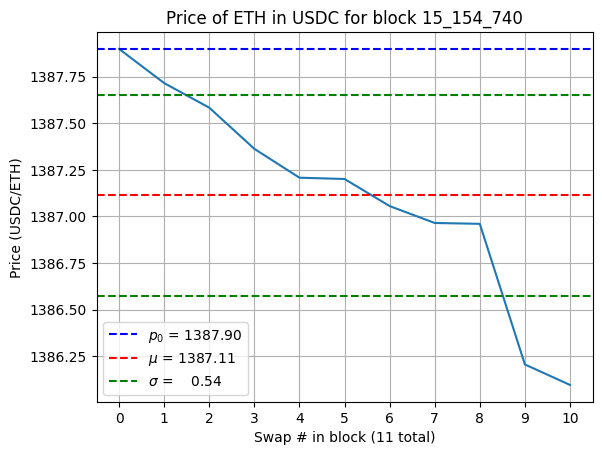

In [64]:

# Create random order of swaps
swaps_parameters_random = get_swap_params_random(swaps_parameters)

# Run the simulation with the random order
prices_random = run_simulation(pool, block_number, swaps_parameters_random)

# Plot the prices
plot_prices(prices_random, block_number)

### Compare 8 random permutations with the original and 1 interleaved

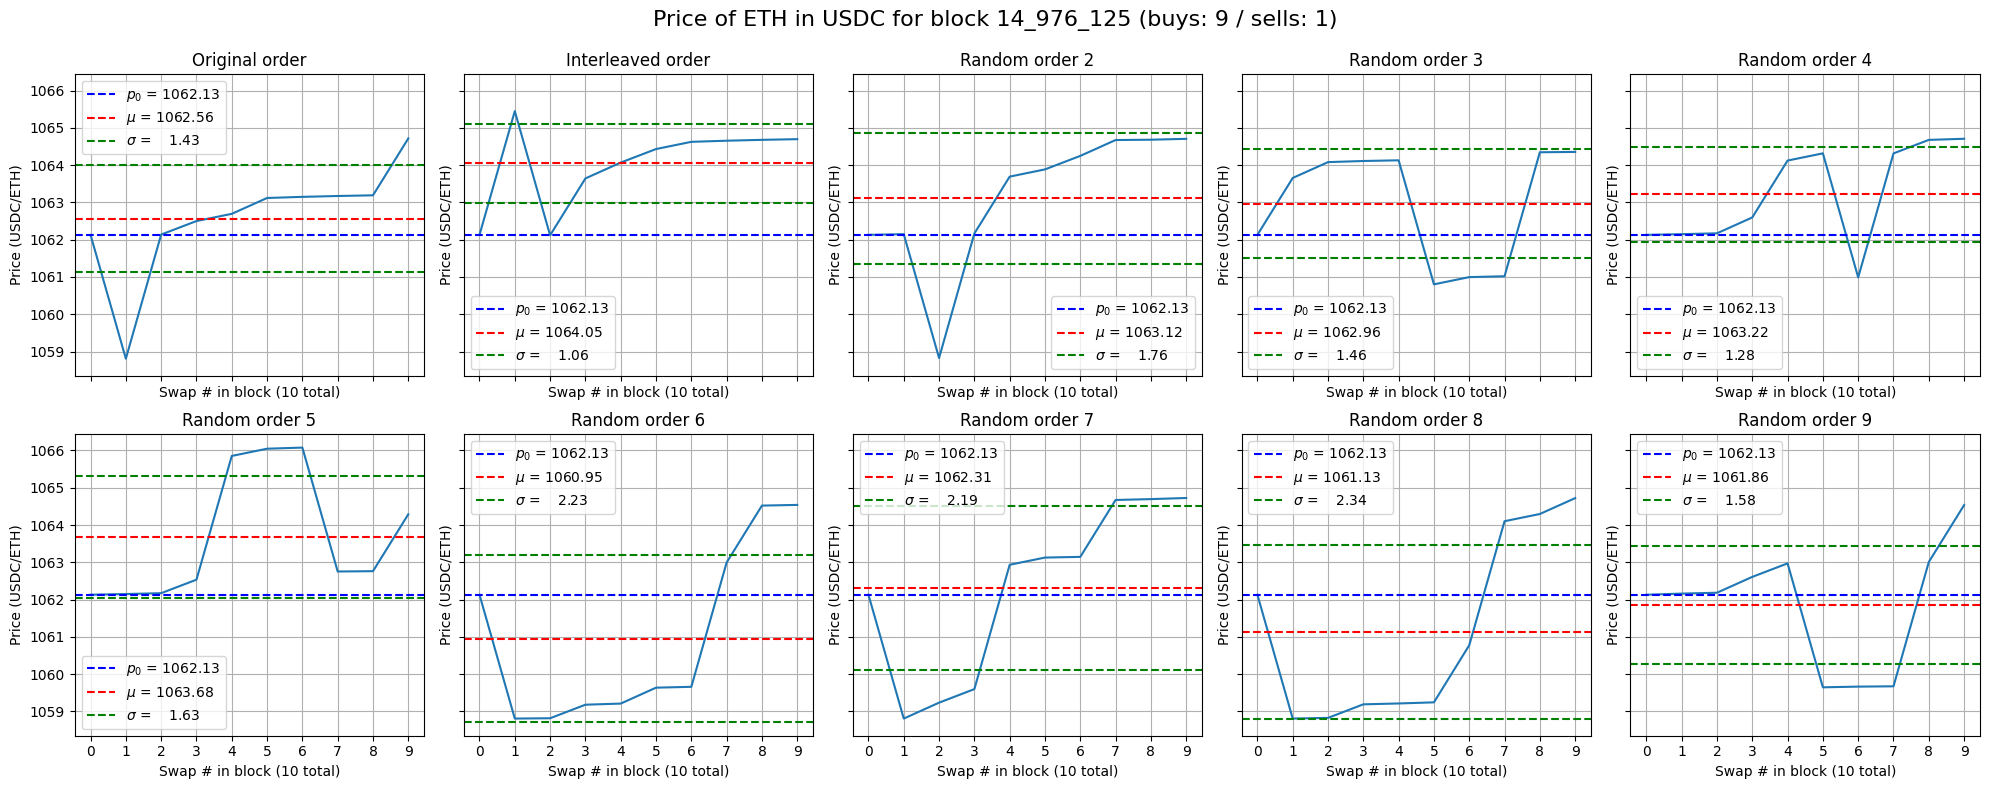

In [65]:
def make_price_grid(pool: v3Pool, block_number: int, all_swaps_df: pd.DataFrame, nrows=2, ncols=5, pbar=True) -> None:
    # Make a progress bar
    it = tqdm(total=nrows * ncols, desc='Making plots', unit='plot', leave=False, disable=not pbar)

    # Get the swaps for the block
    swap_df = get_swap_df_from_block(all_swaps_df, block_number)

    # Get the swap parameters
    swaps_parameters = get_swap_params(pool, swap_df)

    # Make 2 by 5 grid of plots
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows), sharex=True, sharey=True)

    # Flatten the axes
    ax = ax.flatten()

    # Add the original plot to the first axis
    prices = run_simulation(pool, block_number, swaps_parameters, pbar=False)
    plot_prices(prices, block_number, ax=ax[0])
    ax[0].set_title('Original order')
    it.update()

    # Add the interleaved plot to the second axis
    interleaved_swaps_parameters = interleave_swaps(swaps_parameters)
    interleaved_prices = run_simulation(pool, block_number, interleaved_swaps_parameters, pbar=False)
    plot_prices(interleaved_prices, block_number, ax=ax[1])
    ax[1].set_title('Interleaved order')
    it.update()

    # Plot the prices
    for i in range(2, len(ax)):
        # Create random order of swaps
        swaps_parameters_random = swaps_parameters.copy()
        random.shuffle(swaps_parameters_random)
        prices_random = run_simulation(pool, block_number, swaps_parameters_random, pbar=False)
        plot_prices(prices_random, block_number, ax=ax[i])
        ax[i].set_title(f'Random order {i}')
        it.update()

    # Make the plot nice
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    n_buys = len([s for s in swaps_parameters if s['tokenIn'] == pool.token0])
    n_sells = len([s for s in swaps_parameters if s['tokenIn'] == pool.token1])
    fig.suptitle(f'Price of ETH in USDC for block {block_number:_} (buys: {n_buys} / sells: {n_sells})', fontsize=16);

    # Show the plot
    plt.show()

make_price_grid(pool, swap_counts.index[8], df, pbar=False)

### Look at more blocks

Making plots:   0%|          | 0/10 [00:00<?, ?block/s]

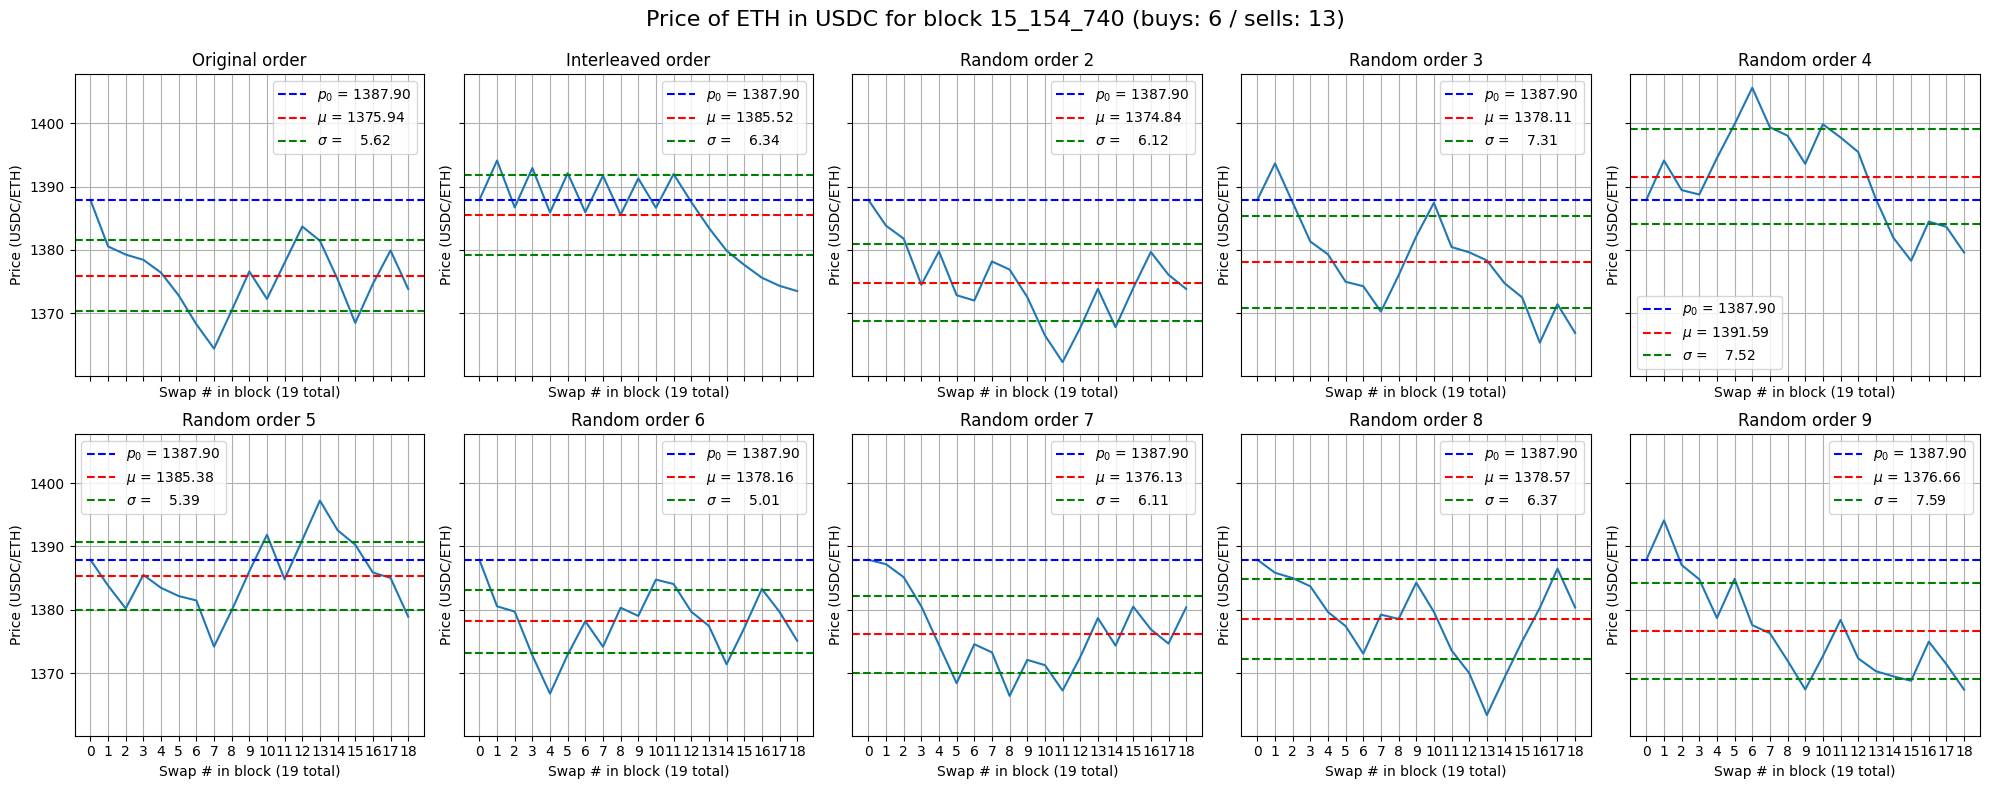

Making plots:  10%|█         | 1/10 [00:10<01:31, 10.13s/block]

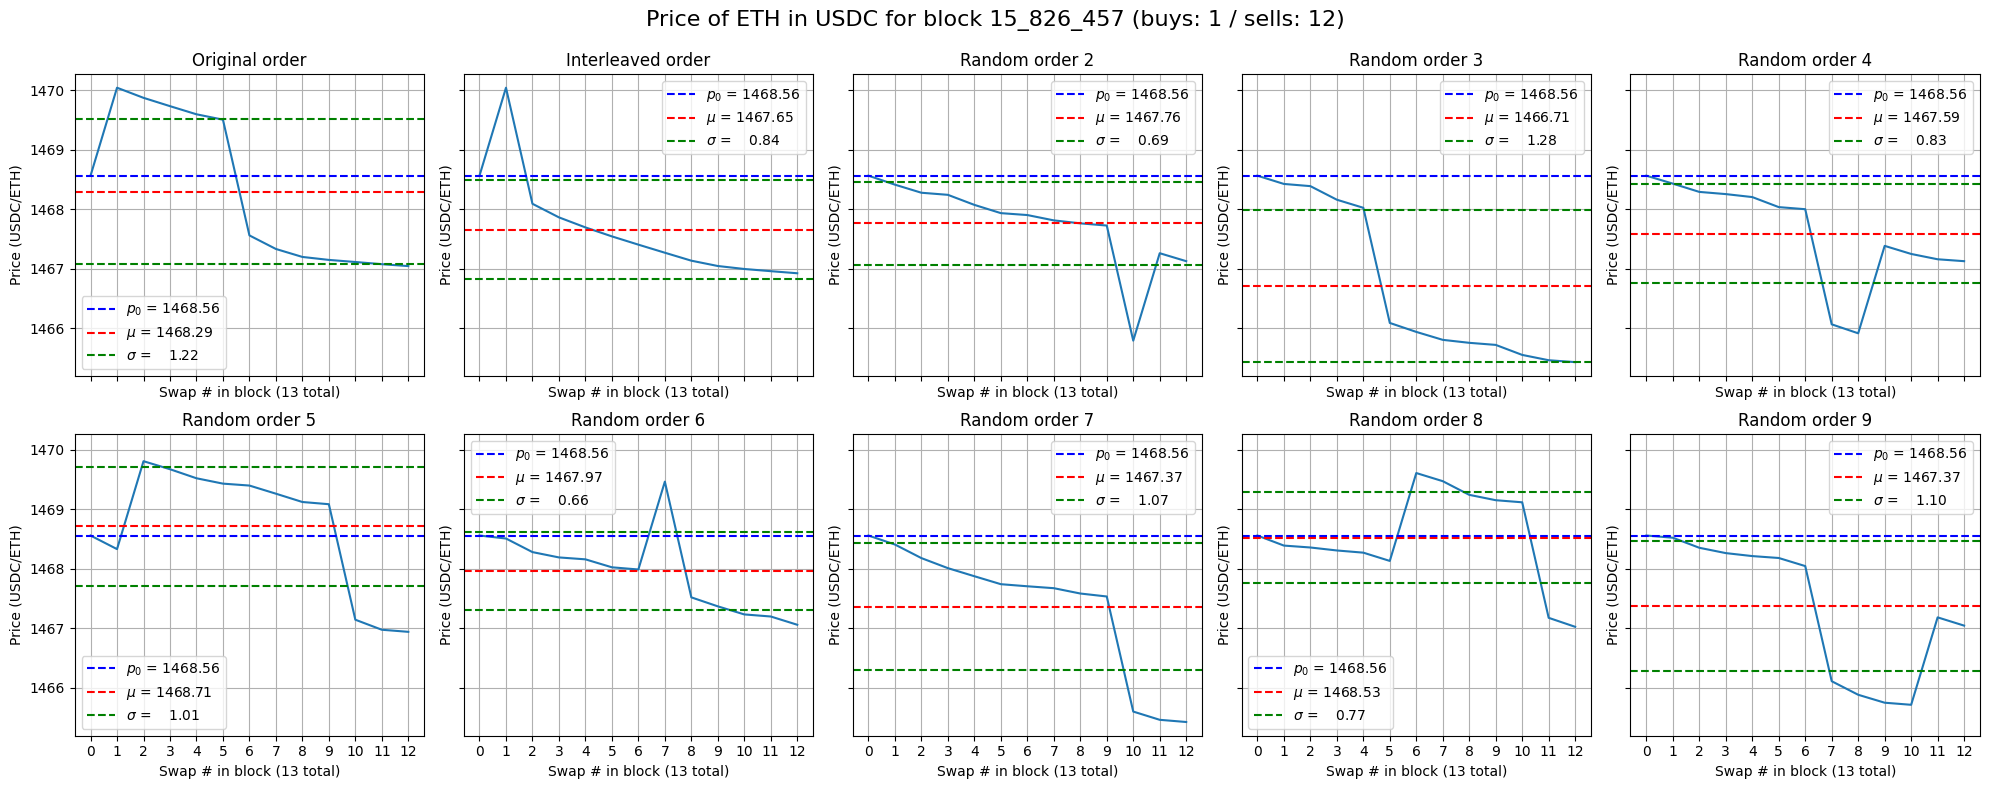

Making plots:  20%|██        | 2/10 [00:17<01:10,  8.79s/block]

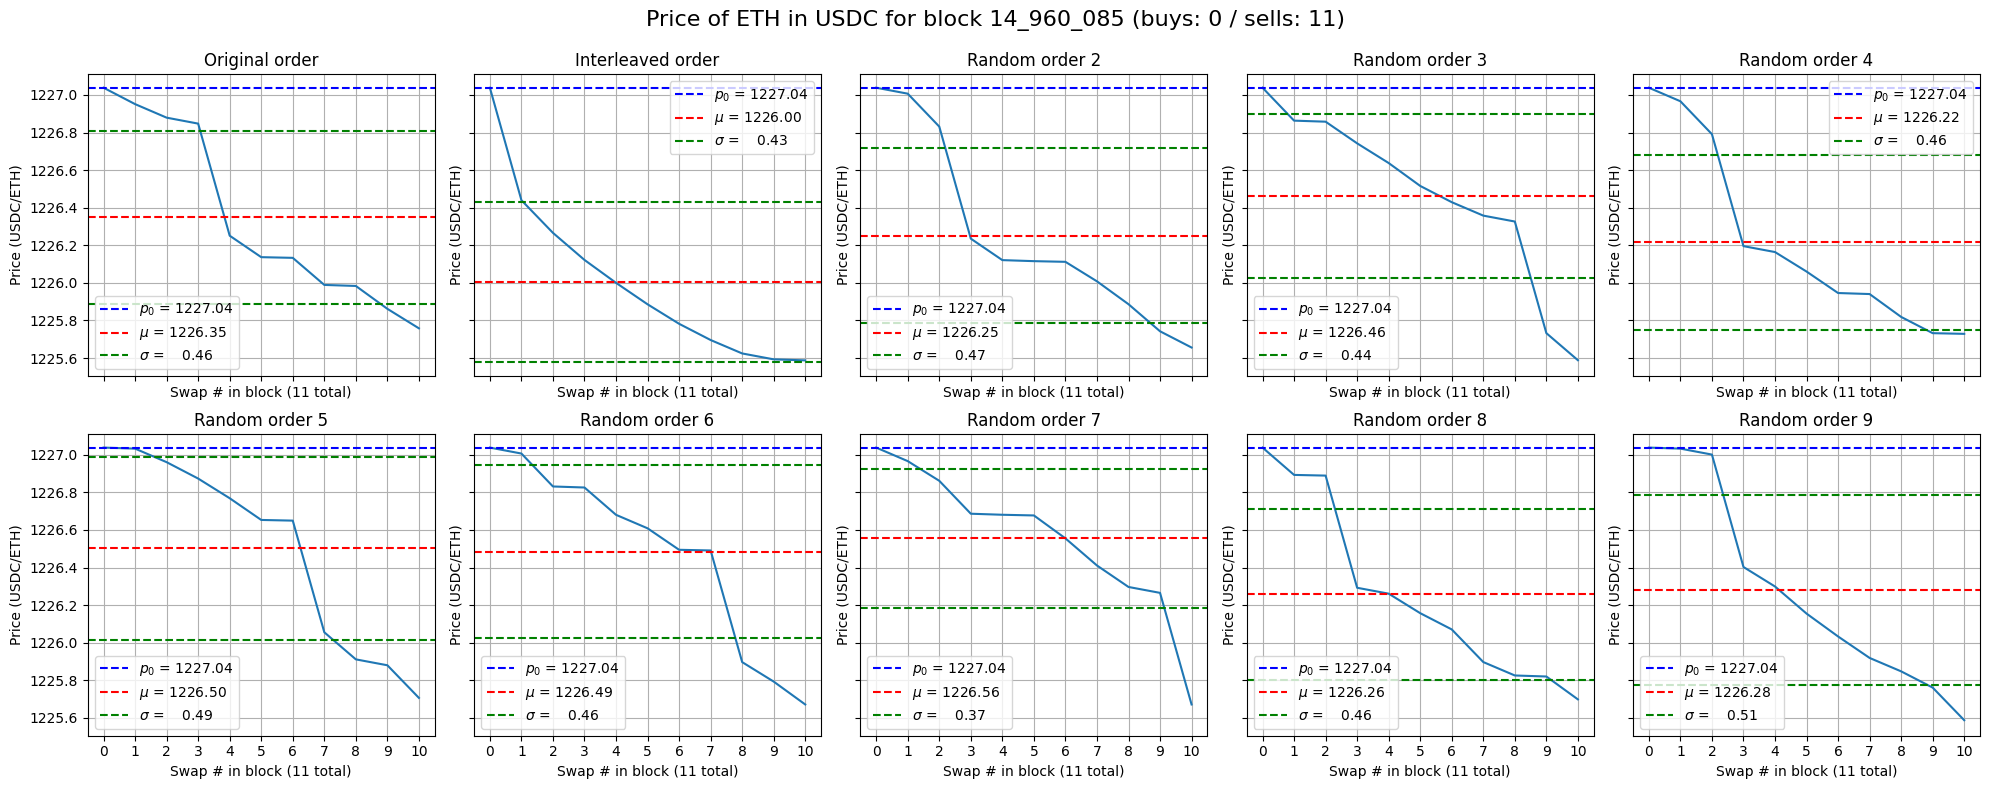

Making plots:  30%|███       | 3/10 [00:23<00:52,  7.46s/block]

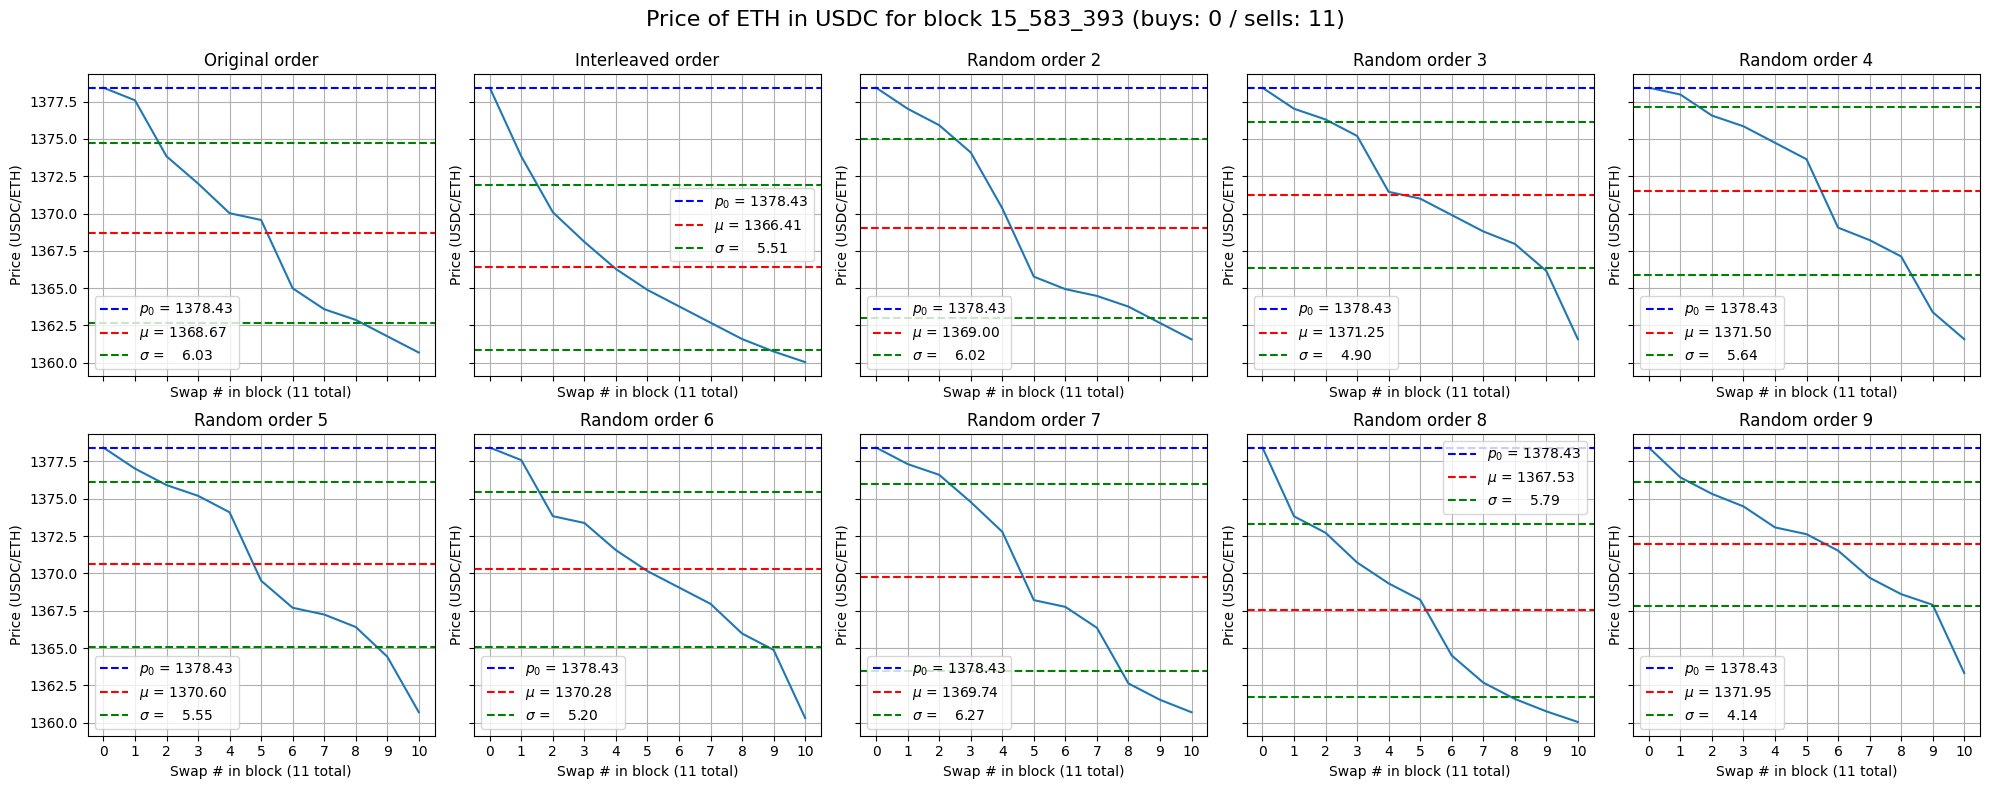

Making plots:  40%|████      | 4/10 [00:30<00:42,  7.06s/block]

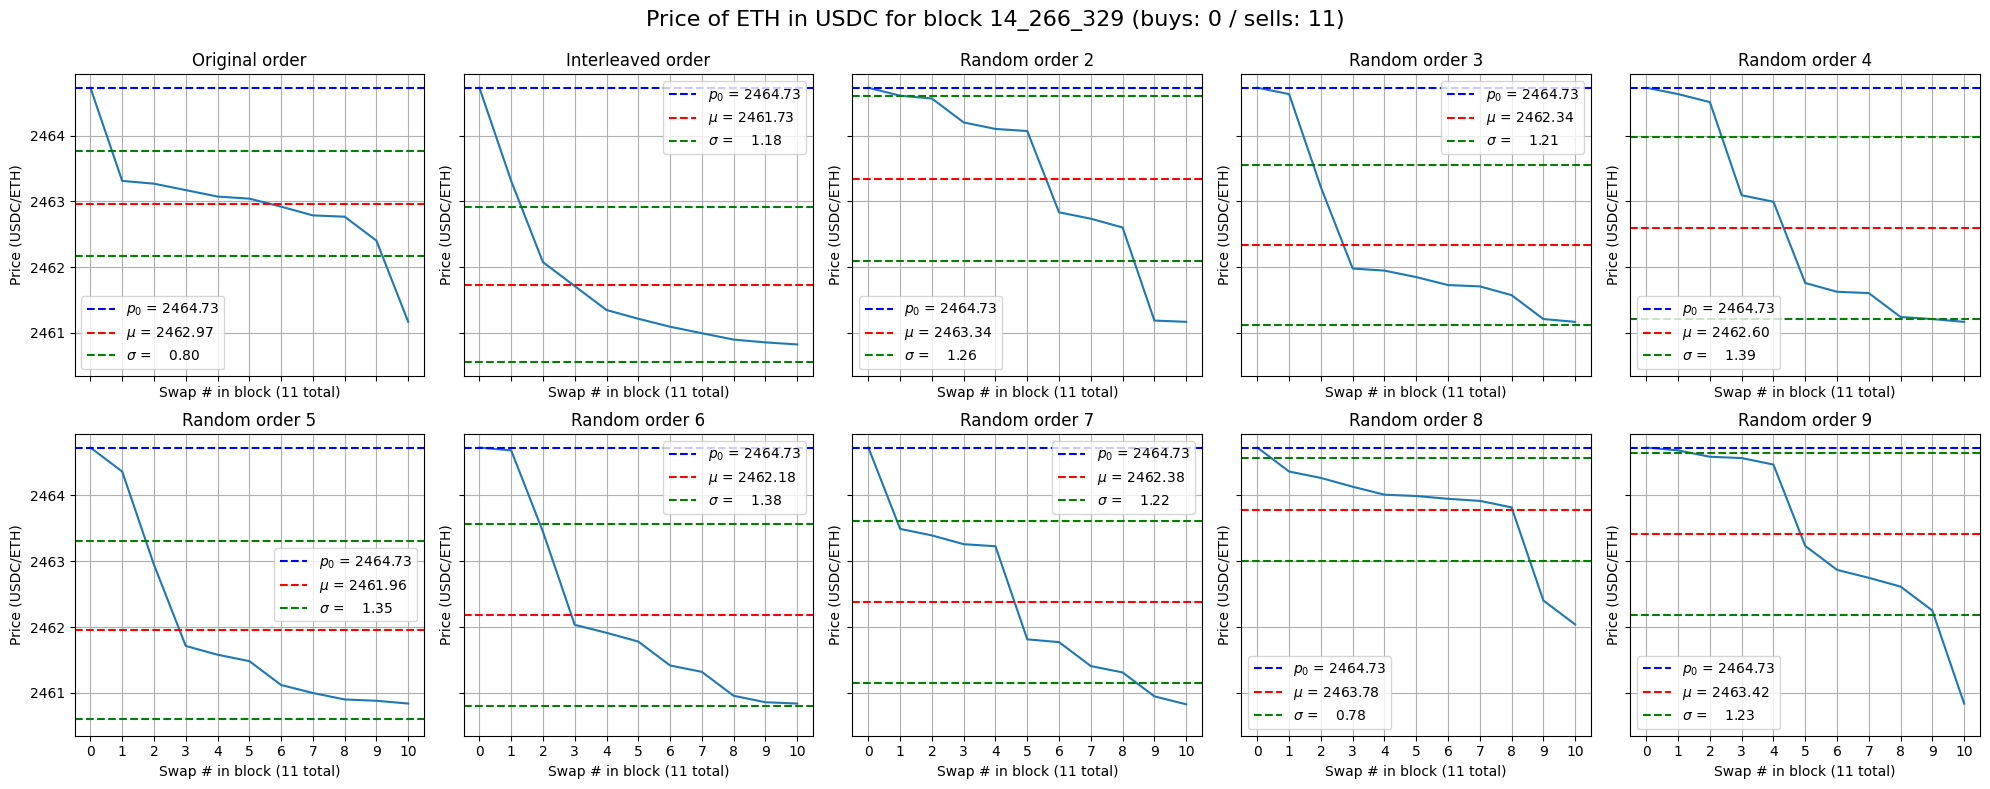

Making plots:  50%|█████     | 5/10 [00:35<00:32,  6.43s/block]

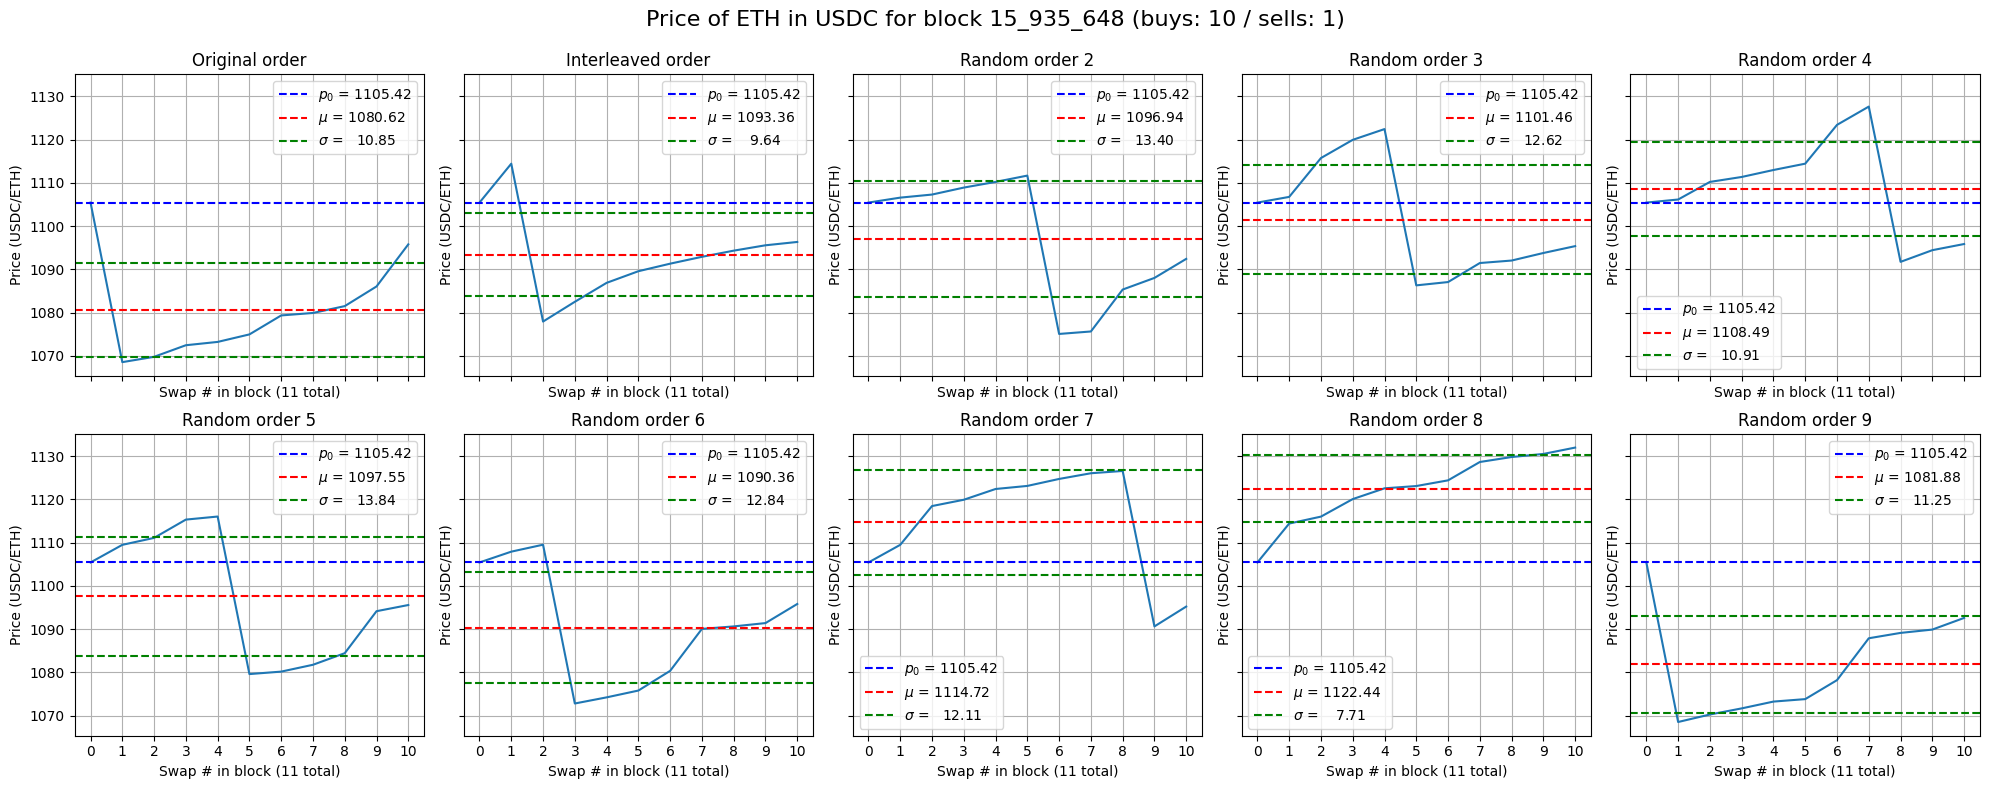

Making plots:  60%|██████    | 6/10 [00:42<00:26,  6.55s/block]

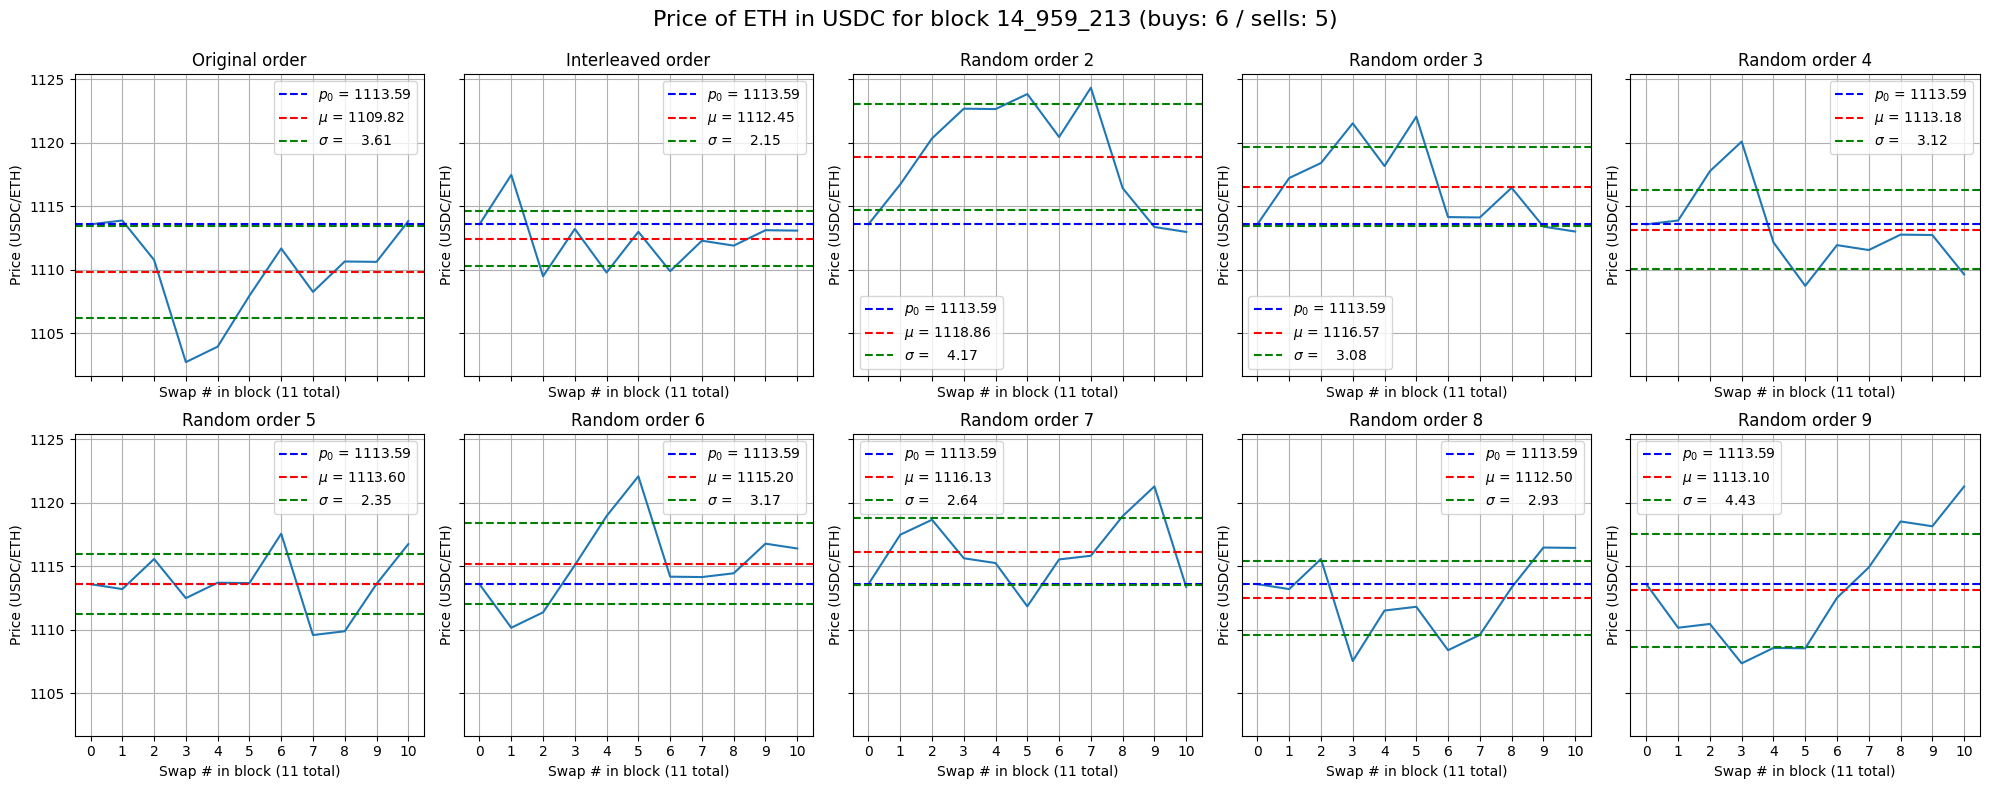

Making plots:  70%|███████   | 7/10 [00:48<00:19,  6.35s/block]

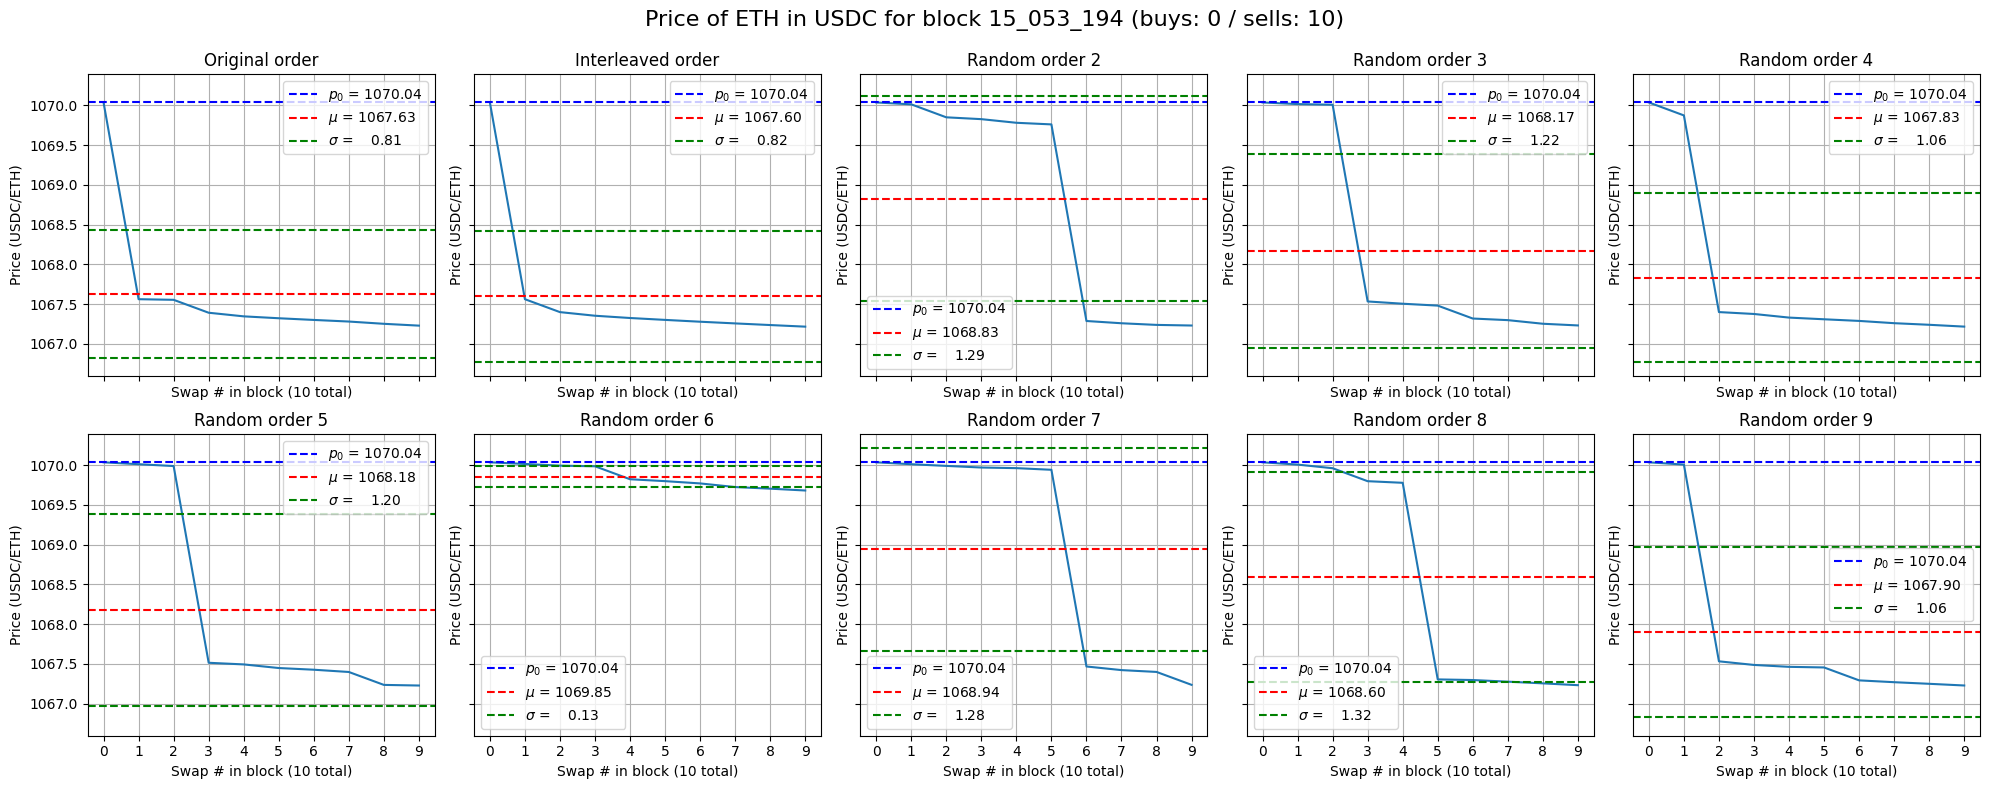

Making plots:  80%|████████  | 8/10 [00:53<00:12,  6.09s/block]

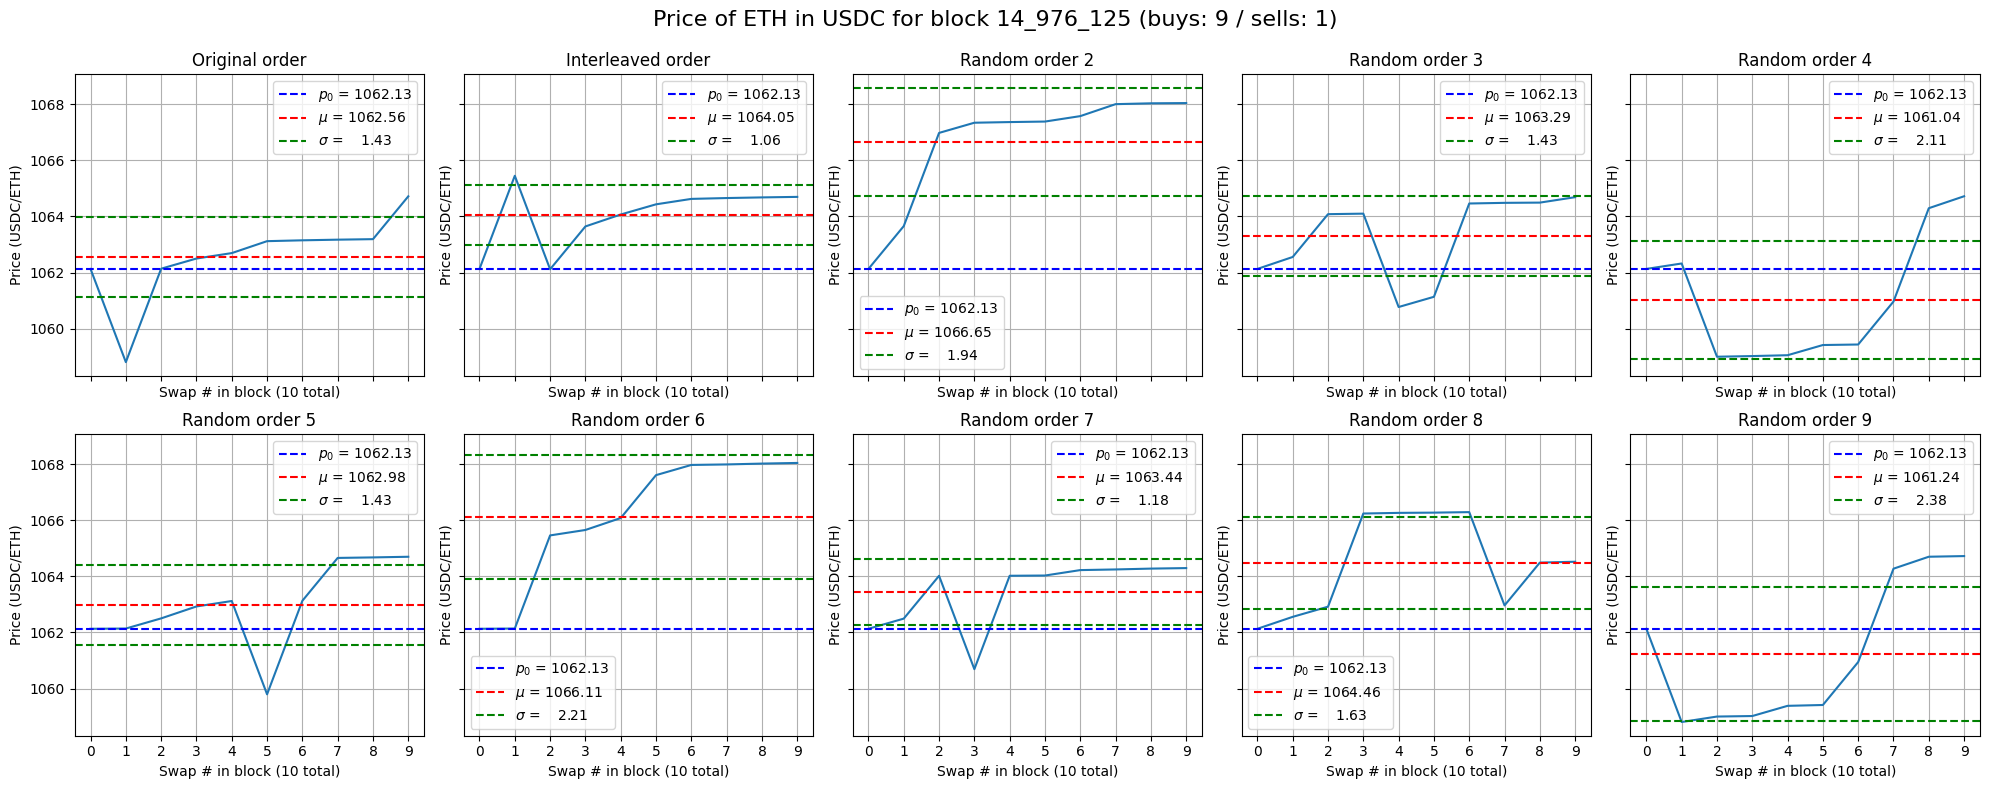

Making plots:  90%|█████████ | 9/10 [00:59<00:05,  5.94s/block]

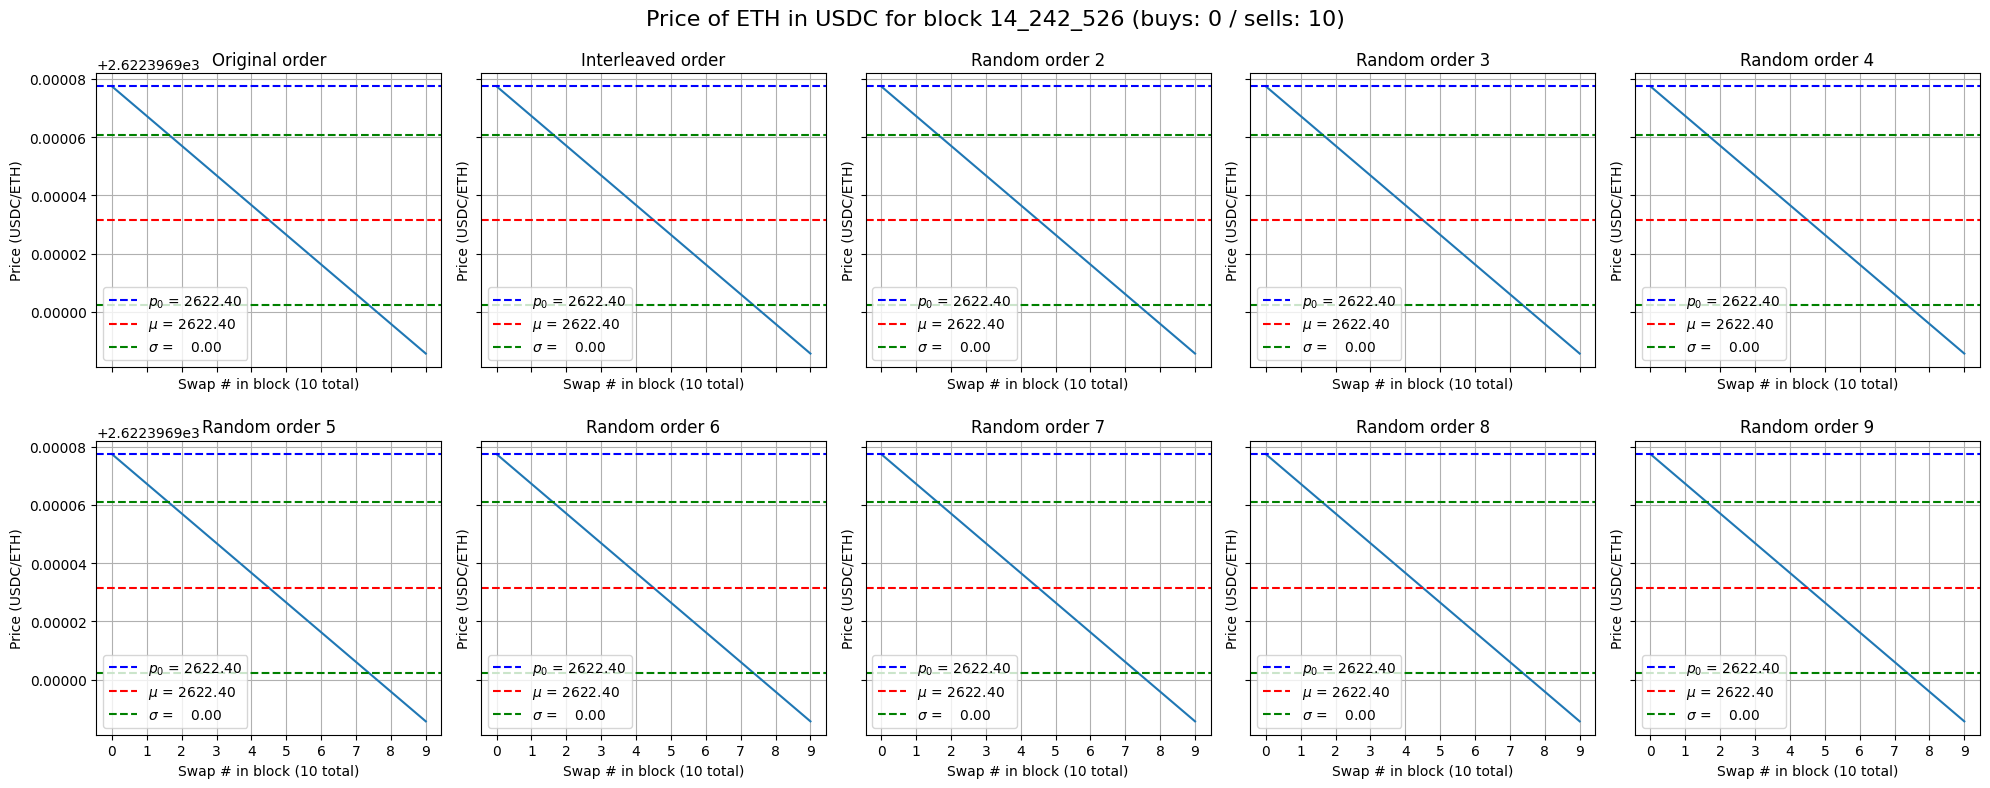

In [41]:
for block_num in tqdm(swap_counts.index[:10], desc='Making plots', unit='block', leave=False):

    # Get the swaps for this block
    make_price_grid(pool, block_num, df, pbar=False)

### Look at density of 1_000 random runs

In [68]:
from os import cpu_count
from pathos.multiprocessing import ProcessingPool as Pool
import random
from functools import partial

from tqdm import trange

# Get the swaps for the block
block_num = int(swap_counts.index.to_list()[0])
swap_df = get_swap_df_from_block(df, block_num)

# Get the swap parameters
swaps_parameters = get_swap_params(pool, swap_df)

def run_simulation_with_random_swaps(_, *, pool=pool, block_num=block_num, swaps_parameters=swaps_parameters):
    swaps_parameters_random = swaps_parameters.copy()
    random.shuffle(swaps_parameters_random)
    prices_random = run_simulation(pool, block_num, swaps_parameters_random, pbar=False)
    return prices_random

n_simulations = 5

sim = partial(run_simulation_with_random_swaps, pool=pool, block_num=block_num, swaps_parameters=swaps_parameters)

results = np.zeros((n_simulations, len(swaps_parameters)), dtype=np.float64)

for i in trange(n_simulations, desc='Running simulations', unit='simulation', leave=False):
    results[i] = sim(i)


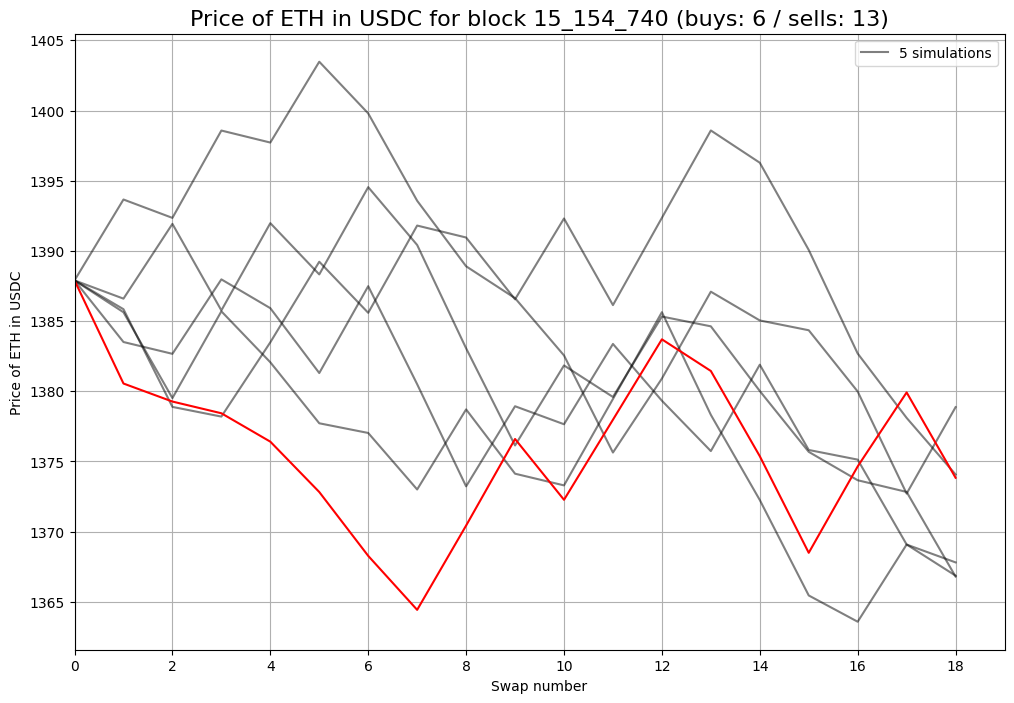

In [71]:
# Import MaxNLocator
from matplotlib.ticker import MaxNLocator

# Plot every line on the same plot to get the density
fig, ax = plt.subplots(figsize=(12, 8))

for i in range(len(results)):
    ax.plot(results[i], color="black", alpha=0.5)

# Plot the original order in red
prices = run_simulation(pool, block_num, swaps_parameters, pbar=False)
ax.plot(prices, color="red", label="Original order")

# Calculate the number of buys and sells
n_buys = len([s for s in swaps_parameters if s["tokenIn"] == pool.token0])
n_sells = len([s for s in swaps_parameters if s["tokenIn"] == pool.token1])

# Find the mean of the results and plot it
mean = results.mean(axis=0)
# ax.plot(mean, color='red', label='Mean')

# Make the x-axis tick labels integers
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Make the plot nice
ax.set_title(
    f"Price of ETH in USDC for block {swap_counts.index[0]:_} (buys: {n_buys} / sells: {n_sells})",
    fontsize=16,
)
ax.set_xlabel("Swap number")
ax.set_ylabel("Price of ETH in USDC")
ax.set_xlim(0, len(swaps_parameters))
# ax.set_ylim(0.9 * results.min(), 1.1 * results.max())
ax.grid(True)

# Show the legend containing the number of simulations
ax.legend([f"{len(results):_} simulations"])

## Todo for Monday July 3rd

1. Insert the mempool transactions from MongoDB into Postgres
2. Set up code that continuously puts in the latest block into all the Uniswap Postgres tables
3. Implement some version of the Sequencing rule
4. Run the above analysis of much more data, and accross many different pools (smaller pools might be more interesting)
5. Compare the average size of orders across based on transaction origin (i.e., mempool / non-mempool)